## Import packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
set_config(display='diagram')

# Read Data From Files

In [2]:
train_X_df = pd.read_csv('data/training.csv')
train_y_sr = train_X_df['condition']
train_X_df.drop(columns='condition', inplace=True)

val_X_df = pd.read_csv('data/validation.csv')
val_y_sr = val_X_df['condition']
val_X_df.drop(columns='condition', inplace=True)

test_X_df = pd.read_csv('data/testing.csv')
test_y_sr = test_X_df['condition']
test_X_df.drop(columns='condition', inplace=True)

# Explore Training Data

### What are the data types of these columns?

In [3]:
train_X_df.dtypes

date            object
time            object
temperature      int64
dew_point        int64
humidity         int64
wind            object
wind_speed       int64
wind_gust        int64
pressure       float64
precip.        float64
dtype: object

### How data distributed on label column

In [4]:
train_y_sr.value_counts()

Others    1703
Rain       189
Name: condition, dtype: int64

### How data distribution of each numerical column

In [5]:
num_cols = list(train_X_df.select_dtypes(exclude='object').columns)
cate_cols = list(train_X_df.select_dtypes(include='object').columns)

In [6]:
train_X_df[num_cols].describe()

,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip.
count,1892.000000,1892.000000,1892.000000,1892.000000,1892.000000,1892.000000,1892.0
mean,82.939218,77.035412,83.548097,7.121564,0.331924,29.725973,0.0
std,4.779872,2.005100,13.043892,4.779984,3.349669,0.052494,0.0
min,72.000000,70.000000,46.000000,0.000000,0.000000,29.580000,0.0
25%,79.000000,75.000000,74.000000,3.000000,0.000000,29.700000,0.0
50%,82.000000,77.000000,89.000000,7.000000,0.000000,29.730000,0.0
75%,86.000000,79.000000,94.000000,10.000000,0.000000,29.760000,0.0
max,97.000000,82.000000,100.000000,26.000000,44.000000,29.910000,0.0


* We visualize the histogram to have a better look

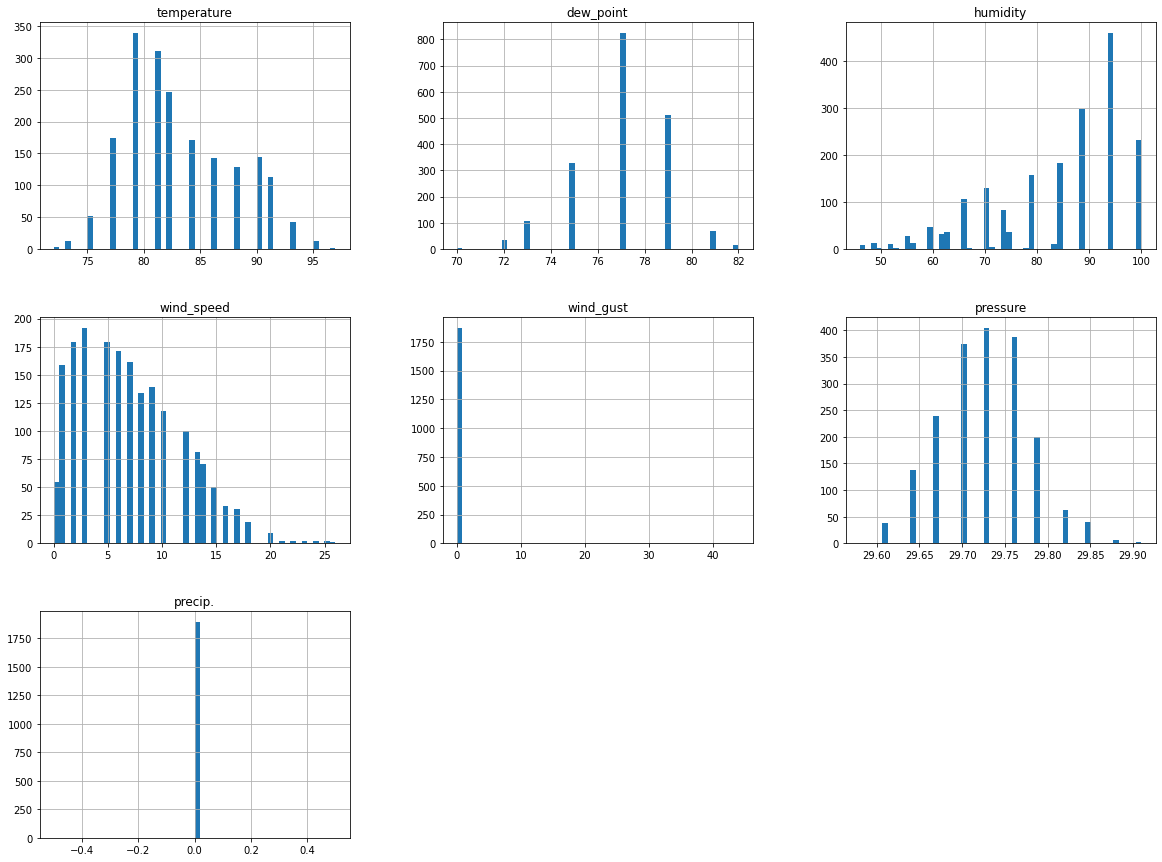

In [7]:
train_X_df[num_cols].hist(bins=50, figsize=(20, 15))
plt.show()

#### We have few observations:
* These attributes have very different scales.
* `precip` and `wind_gust` column are all most $0$, so this attributes do not supply any information.

### Now look at correlation

In [8]:
train_X_df[num_cols].corr()

,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip.
temperature,1.000000,0.006846,-0.934009,0.370674,-0.007888,-0.299913,NaN
dew_point,0.006846,1.000000,0.336656,0.106646,-0.047024,-0.005879,NaN
humidity,-0.934009,0.336656,1.000000,-0.326879,-0.011125,0.264505,NaN
wind_speed,0.370674,0.106646,-0.326879,1.000000,0.205686,-0.373418,NaN
wind_gust,-0.007888,-0.047024,-0.011125,0.205686,1.000000,-0.081263,NaN
pressure,-0.299913,-0.005879,0.264505,-0.373418,-0.081263,1.000000,NaN
precip.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/ubuntu/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/ubuntu/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


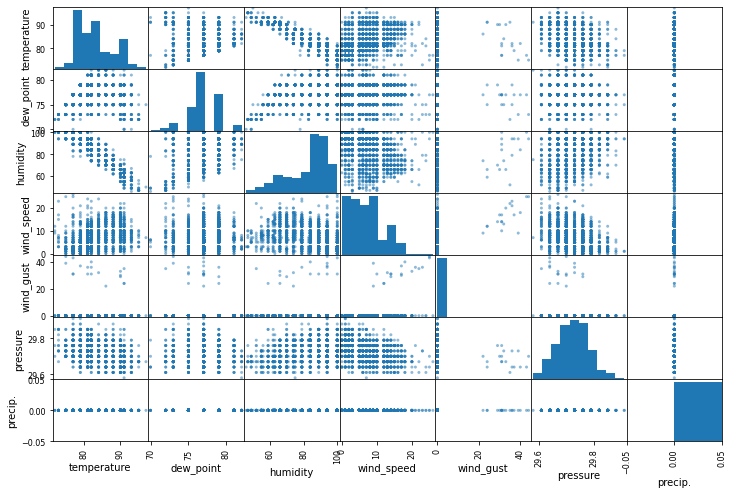

In [9]:
pd.plotting.scatter_matrix(train_X_df[num_cols], figsize=(12,8))
plt.show()

It seems that just only pair `humidity` and `temperature` have strong correlation.

### How data distribute of each categorical column

In [10]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)

def CountUniqueValues(s):
    s = s.dropna().str.split(';').explode()
    return len(s.unique())
def CountFrequenciesSeries(s):
    s = s.dropna().str.split(';').explode()
    return (s.value_counts(normalize = True)*100).round(1).to_dict()

cate_col_info_df = pd.DataFrame(index=['missing_percentage', 'num_values', 'value_percentages'], columns=cate_cols)
cate_col_info_df.loc['missing_percentage'] = train_X_df[cate_cols].isnull().sum(axis = 0).divide(len(train_X_df) / 100).round(1)
cate_col_info_df.loc['num_values'] = train_X_df[cate_cols].apply(CountUniqueValues)
cate_col_info_df.loc['value_percentages'] = train_X_df[cate_cols].apply(CountFrequenciesSeries)
cate_col_info_df

,date,time,wind
missing_percentage,0.0,0.0,0.0
num_values,66,48,18
value_percentages,"{'2021-09-03': 1.9, '2021-08-27': 1.8, '2021-08-23': 1.7, '2021-08-14': 1.7, '2021-07-06': 1.7, ...","{'2:30 PM': 2.5, '11:30 AM': 2.4, '10:30 PM': 2.4, '4:30 AM': 2.4, '6:00 PM': 2.3, '11:00 AM': 2...","{'WSW': 25.6, 'VAR': 20.6, 'W': 16.4, 'SW': 11.4, 'WNW': 4.3, 'SSW': 3.1, 'S': 3.0, 'CALM': 2.9,..."


* We visualize data for more obvious

/home/ubuntu/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


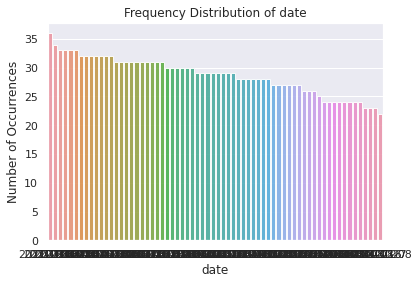

In [11]:
count = train_X_df['date'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of date')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('date', fontsize=12)
plt.show()

/home/ubuntu/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


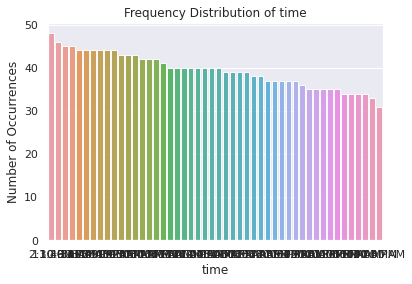

In [12]:
count = train_X_df['time'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of time')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('time', fontsize=12)
plt.show()

/home/ubuntu/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


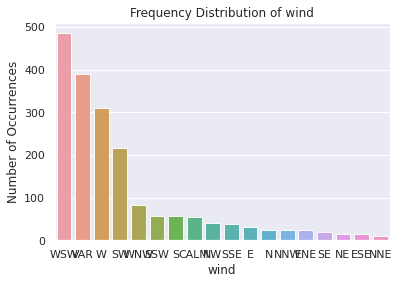

<Figure size 17280x8640 with 0 Axes>

In [13]:
count = train_X_df['wind'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of wind')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('wind', fontsize=12)
plt.figure(figsize=(240, 120))
plt.show()

#### We have some observations:
* Distribution of `date` and `time` is uniform.
* `wind` has some values which frequency are low.
* There are different weather labels that show it's raining.

# Preprocess data
Accroding to analysis in exploring data. There are what we will do:
* Remove `precip.`, `wind_gust` columns because it does not supply any useful information.
* Remove `date` column. The month can effect on weather, but the data we have only 3 months (July, August, September), therfore with new data, which occure in another months, model can be confused. In addition, we want to make model learning online, it means the data and model will be updated frequently, so that we think `date` column is not useful.
* Split `time` into `time` and `day_night`.
* With two unorder categorical columns `time`, `day_night` and `wind`, we use one hot encoding, in addition, because some values in wind appear very few, so we use a hyperparameter to keep the topmost frequent values.
* Convert label values into "Rain" and "Others".

In [14]:
rain = {'Light Rain':"Rain",'Light Rain Shower':"Rain",'Light Rain with Thunder':"Rain",'T-Storm':"Rain",'Rain Shower':"Rain",'Heavy T-Storm':"Rain",'Showers in the Vicinity':"Rain",'Light Rain Shower / Windy':"Rain",'Heavy Rain Shower':"Rain",'Heavy T-Storm / Windy':"Rain",'Heavy Rain Shower / Windy':"Rain",'Rain Shower / Windy':"Rain",'Partly Cloudy':"Others",'Mostly Cloudy':"Others",'Fair':"Others",'Thunder in the Vicinity':"Others",'Thunder':"Others",'Partly Cloudy / Windy':"Others",'Fog':"Others",'Mostly Cloudy / Windy':"Others"}

In [15]:
train_y_sr = train_y_sr.replace(rain)
val_y_sr = val_y_sr.replace(rain)
test_y_sr = test_y_sr.replace(rain)

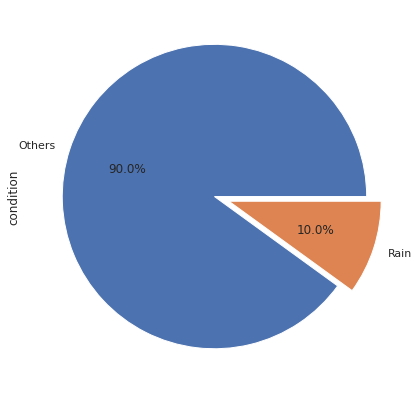

In [16]:
train_y_sr.value_counts(normalize = True).plot.pie(figsize=(7, 7),autopct='%1.1f%%',explode=(0, 0.1))
plt.show()

In [17]:
class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_wind=1):
        self.num_top_wind = num_top_wind
    def fit(self, X_df, y=None):
        wind_col = X_df.wind
        self.wind_counts_ = wind_col.value_counts()
        wind = list(self.wind_counts_.index)
        self.top_wind_ = wind[:max(1, min(self.num_top_wind, len(wind)))]
        return self
    def transform(self, X_df, y=None):
        temp_df = X_df.copy(deep = True)
        wind_col = temp_df.wind.str.extract(r'([A-Z]+)',expand = False)
        wind_col[~wind_col.isin(self.top_wind_)] = 'Others'
        temp = pd.DataFrame(temp_df.time.str.split().tolist(),columns = ['t','dn'])
        temp_df['day_night'] =  list(temp['dn'])
        temp_df['time'] = list(temp['t'])
        temp_df.drop(['precip.','date','wind_gust'], axis=1, inplace=True)
        return temp_df

* Test `Preprocess` class

In [18]:
col_preprocess = Preprocess(num_top_wind=4)

In [19]:
fewer_cols_train_X_df = col_preprocess.fit_transform(train_X_df)

In [20]:
fewer_cols_train_X_df.head(5)

,time,temperature,dew_point,humidity,wind,wind_speed,pressure,day_night
0,2:30,79,75,89,VAR,2,29.73,AM
1,4:30,79,77,94,SW,5,29.70,AM
2,11:00,90,77,66,SW,12,29.70,AM
3,2:30,91,77,63,WSW,9,29.67,PM
4,2:30,79,77,94,VAR,1,29.76,AM


We will continue to preprocess following these steps:

- Numerical columns, we will fill in missing values with mean value
- Unorder categorical columns: `time`, `day_night` and `wind`: 
    - Convert to numerical using one-hot encoding method.
- Normalize data.

We will create a pipeline that executes these steps and also include the `Preprocess` class above.

In [21]:
num_cols = ['temperature','dew_point','humidity','wind_speed','pressure']
cate_cols = ['time','wind','day_night']

preprocess_pipeline = Pipeline(steps = [('preprocess_cate',Preprocess(num_top_wind=4)),
                                    ('imputer', ColumnTransformer(transformers=[('nume', SimpleImputer(missing_values = np.nan, strategy='mean'),num_cols),
                                        ('cate', OneHotEncoder(categories='auto', handle_unknown='ignore'), cate_cols)])),
                                   ('scale', StandardScaler(with_mean=False))])

* Test `preprocess_pipeline`

In [22]:
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

In [23]:
preprocessed_train_X.shape

(1892, 49)

# Models
We will try some models and evaluate them to get a good model. There are models we will run:
* Traditional Machine Learning:
    * Linear model:
        * Logistic model
        * Linear SVM
    * Non-linear model:
        * kNN
        * Nonlinear SVM
    * Tree:
        * Decision tree
        * Random Forest
* Deep learning: Neural network

Because we focus on forecast raining weather, and in our data, raining condition is the minority. Therefore, we use the f1 score of the raining class to be our metric.

Each model, we iterate hyperparameters and calculate the score on training and validation, then we choose hyparameters get the best result. The number of hyperparameters depends on models.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

## Linear models
### Logistic model
Create pipeline for logistic model

In [25]:
logistic_model = make_pipeline(preprocess_pipeline, LogisticRegression(max_iter=500))

Because most of algorithms we use have only one hyperparameter, we write function `Run_One_Hyper_Model` to train and evaluate that algorithms. The function takes `top_winds` and `model` as the parameters. `top_winds` is a list of `num_top_wind`. The function returns traning scores, validation scores, the best validation score and the best value of hyperparameter.

In [26]:
# logistic_model.get_params().keys()
def Run_One_Hyper_Model(top_winds, model):
    train_errs = []
    val_errs = []
    best_val_err = -float('inf')
    best_num_top_wind = None
#     top_winds = [4, 6, 8, 10, 14]
    for num_top_wind in top_winds:
        model.set_params(pipeline__preprocess_cate__num_top_wind=num_top_wind)
        model.fit(train_X_df, train_y_sr)
        train_preds = model.predict(train_X_df)
        train_errs.append(f1_score(train_y_sr, train_preds, pos_label = 'Rain'))
        val_preds = model.predict(val_X_df)
        val_errs.append(f1_score(val_y_sr, val_preds,  pos_label = 'Rain'))
        if val_errs[-1] > best_val_err:
            best_val_err = val_errs[-1]
            best_num_top_wind = num_top_wind
      
    return train_errs, val_errs, best_val_err, best_num_top_wind

# logistic_train_errs, logistic_val_errs, logistic_best, best_num_top_wind = Run_Linear_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], logistic_model)
# logistic_model.fit(train_X_df, train_y_sr)

`Draw_Train_Val_scores` is the function to plot training and validation errors for easlier judge model.

In [27]:
def Draw_Train_Val_scores(train_errs, val_errs, top_winds):
    plt.figure(figsize=(10, 5))
    plt.plot(top_winds, train_errs, 'o-', color = 'red')
    plt.plot(top_winds, val_errs, 'o-', color='blue')
    plt.show()
    
# Draw_Train_Val_scores(logistic_train_errs, logistic_val_errs, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

The result of logistic regression model

Best hyperparameter: 1
Best validation score: 0.16091954022988506


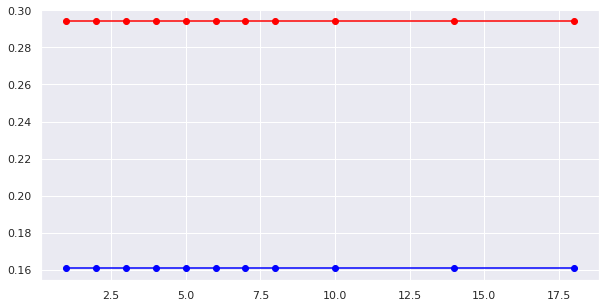

In [28]:
logistic_train_scores, logistic_val_scores, logistic_best, logistic_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], logistic_model)
print('Best hyperparameter: {0}'.format(logistic_wind))
print('Best validation score: {0}'.format(logistic_best))
Draw_Train_Val_scores(logistic_train_scores, logistic_val_scores, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

**Comments:**
* The model is underfitting.
* Feature `wind` does not affect the model.

### Linear SVM


In [29]:
svm_linear = make_pipeline(preprocess_pipeline, SVC(kernel='linear', max_iter=-1))
linear_svm_train_scores, linear_svm_val_scores, linear_svm_best, linear_svm_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], svm_linear)

Best hyperparameter: 1
Best validation score: 0.02631578947368421


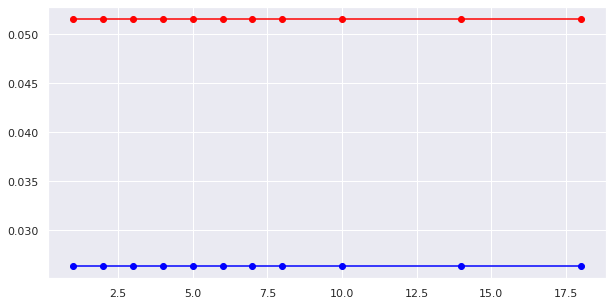

In [30]:
print('Best hyperparameter: {0}'.format(linear_svm_num_top_wind))
print('Best validation score: {0}'.format(linear_svm_best))
Draw_Train_Val_scores(linear_svm_train_scores, linear_svm_val_scores, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

**Comment:**
* The model is underfitting.
* It is even bad than logistic regression.
* Feature `wind` does not affect the model.

## Non-linear models
### kNN model
kNN model has 2 hyperparameters, the number of neighbors and the number of top wind.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn_model = make_pipeline(preprocess_pipeline, KNeighborsClassifier())
n_neighbors_s = [5, 7, 9, 11, 13]
knn_train_scores, knn_val_scores, knn_best, knn_neighbors, knn_num_top_wind = [], [], -float('inf'), None, None
for n_neighbors in n_neighbors_s:
    knn_model.set_params(kneighborsclassifier__n_neighbors=n_neighbors)
    train_s, val_s, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], knn_model)
    knn_train_scores.append(train_s)
    knn_val_scores.append(val_s)
    if best_val > knn_best:
        knn_best = best_val
        knn_num_top_wind = best_para
        knn_neighbors = n_neighbors

# knn_train_errs, knn_val_errs, knn_best, knn_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], knn_model)

In [33]:
def Table_Train_Val_scores(train_errs, val_errs, index, columns, xlabel, ylabel):
    train_errs_df = pd.DataFrame(data=np.array(train_errs),
                             index=index, columns=columns)
    val_errs_df = pd.DataFrame(data=np.array(val_errs), index=index, columns=columns)
    min_err = min(np.array(train_errs).min(), np.array(val_errs).min())
    max_err = max(np.array(train_errs).max(), np.array(val_errs).max())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, 
                annot=True, cbar=False, fmt='.1f', cmap='Reds')
    plt.title('train scores'); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.subplot(1, 2, 2)
    sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, 
                annot=True, cbar=False, fmt='.1f', cmap='Reds')
    plt.title('validation scores'); plt.xlabel(xlabel); plt.ylabel(ylabel);

Best num_top_wind: 4
Best neighbors: 5
Best validation score: 0.05


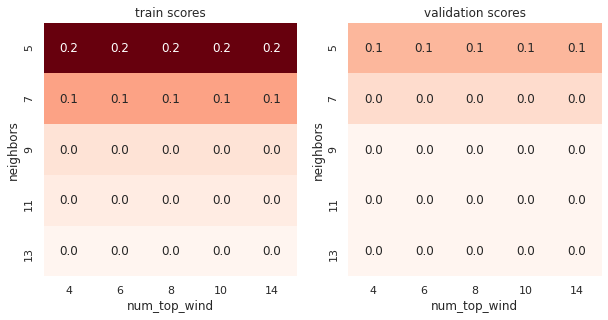

In [34]:
print('Best num_top_wind: {0}'.format(knn_num_top_wind))
print('Best neighbors: {0}'.format(knn_neighbors))
print('Best validation score: {0}'.format(knn_best))
Table_Train_Val_scores(knn_train_scores, knn_val_scores, [5, 7, 9, 11, 13], [4, 6, 8, 10, 14], 'num_top_wind', 'neighbors')

**Comment:**
* The model is underfitting.
* It is even worse than linear models.
* Feature `wind` does not affect the model.
* As low hyperparameter `neighbors`, as good model is.

### Non-Linear SVM
#### Kernel: Poly
We use kernel poly. The model has 2 hyperparameters, the degreeses of poly and the number of top wind.

In [35]:
svm_nonlinear = make_pipeline(preprocess_pipeline, SVC(kernel = 'poly', max_iter=-1))
degreeses = [2, 3, 4]
svm_nonlinear_train_scores, svm_nonlinear_val_scores, svm_nonlinear_best, svm_nonlinear_degrees, svm_nonlinear_num_top_wind = [], [], -float('inf'), None, None
for degrees in degreeses:
    svm_nonlinear.set_params(svc__degree=degrees)
    train_s, val_s, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], svm_nonlinear)
    svm_nonlinear_train_scores.append(train_s)
    svm_nonlinear_val_scores.append(val_s)
    if best_val > svm_nonlinear_best:
        svm_nonlinear_best = best_val
        svm_nonlinear_num_top_wind = best_para
        svm_nonlinear_degrees = degrees

# svm_nonlinear = make_pipeline(preprocess_pipeline, SVC(kernel = 'poly', max_iter=-1))
# svm_nonlinear_train_errs, svm_nonlinear_val_errs, svm_nonlinear_best, svm_nonlinear_num_top_wind = Run_Linear_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], svm_nonlinear)

Best num_top_wind: 4
Best degrees: 2
Best validation score: 0.0


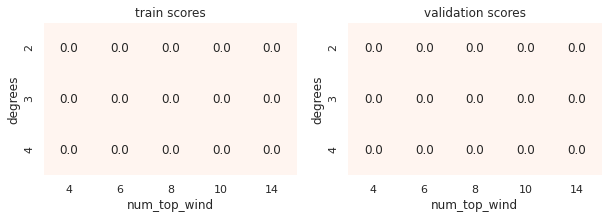

In [36]:
print('Best num_top_wind: {0}'.format(svm_nonlinear_num_top_wind))
print('Best degrees: {0}'.format(svm_nonlinear_degrees))
print('Best validation score: {0}'.format(svm_nonlinear_best))
Table_Train_Val_scores(svm_nonlinear_train_scores, svm_nonlinear_val_scores, [2, 3, 4], [4, 6, 8, 10, 14], 'num_top_wind', 'degrees')

**Comment:**
* The model is underfitting.
* It is the worst.
* Feature `wind` does not affect the model.

## Tree
### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
tree_model = make_pipeline(preprocess_pipeline, DecisionTreeClassifier())
tree_train_scores, tree_val_scores, tree_best, tree_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], tree_model)

Best num_top_wind: 2
Best validation score: 0.366412213740458


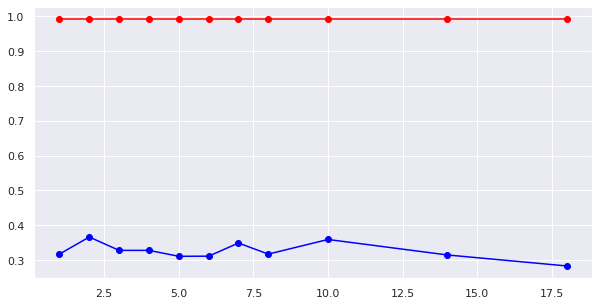

In [39]:
print('Best num_top_wind: {0}'.format(tree_num_top_wind))
print('Best validation score: {0}'.format(tree_best))
Draw_Train_Val_scores(tree_train_scores, tree_val_scores, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

**Comment:**
* The model is very overfitting, the score is high on training set but low on validation.
* It has the best performance until now.

### Random forest
This model has 2 hyperparameters. The first is `max_depth`, we use it to prevent overfitting. 

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
trees_model = make_pipeline(preprocess_pipeline, RandomForestClassifier())
trees_train_scores, trees_val_scores, trees_best, trees_max_depth, trees_num_top_wind = [], [], -float('inf'), None, None
max_depths = [3, 5, 8, 10, 15]
for max_depth in max_depths:
    trees_model.set_params(randomforestclassifier__max_depth=max_depth)
    train_s, val_s, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], trees_model)
    trees_train_scores.append(train_s)
    trees_val_scores.append(val_s)
    if best_val > trees_best:
        trees_best = best_val
        trees_num_top_wind = best_para
        trees_max_depth = max_depth

# trees_train_errs, trees_val_errs, trees_best, trees_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], tree_model)

Best num_top_wind: 4
Best max_depth: 15
Best validation score: 0.2696629213483146


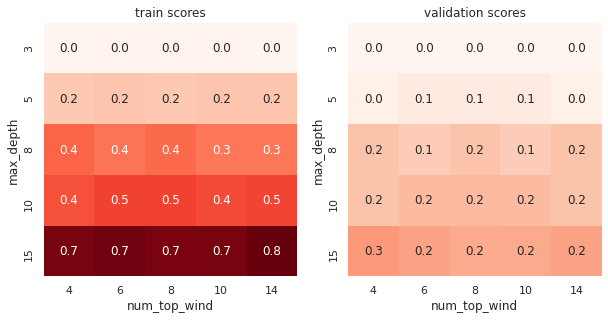

In [42]:
print('Best num_top_wind: {0}'.format(trees_num_top_wind))
print('Best max_depth: {0}'.format(trees_max_depth))
print('Best validation score: {0}'.format(trees_best))
Table_Train_Val_scores(trees_train_scores, trees_val_scores, [3, 5, 8, 10, 15], [4, 6, 8, 10, 14], 'num_top_wind', 'max_depth')

**Comment:**
* The model is overfitting, the score is high on training set but low in on validation.
* It has the best performance until now.
* As large `max_depth` is, as overfitting model is, and as high the f1 score validation is.
* Feature `wind` seems does not affect much.

## Deep learning: Multi layer perceptron


In [43]:
from sklearn.neural_network import MLPClassifier
mlp_model = make_pipeline(preprocess_pipeline, MLPClassifier(hidden_layer_sizes = (100)))
mlp_train_scores, mlp_val_scores, mlp_best, mlp_alpha, mlp_num_top_wind = [], [], -float('inf'), None, None
alphas = [0.001, 0.01, 0.1, 1, 10]
for alpha in alphas:
    mlp_model.set_params(mlpclassifier__alpha=alpha)
    train_s, val_s, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], mlp_model)
    mlp_train_scores.append(train_s)
    mlp_val_scores.append(val_s)
    if best_val > mlp_best:
        mlp_best = best_val
        mlp_num_top_wind = best_para
        mlp_alpha = alpha

Best num_top_wind: 10
Best alpha: 0.01
Best validation score: 0.23076923076923075


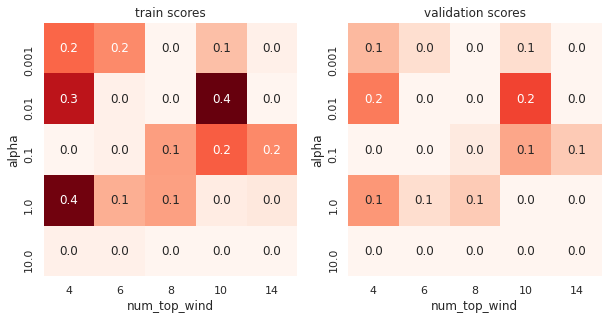

In [44]:
print('Best num_top_wind: {0}'.format(mlp_num_top_wind))
print('Best alpha: {0}'.format(mlp_alpha))
print('Best validation score: {0}'.format(mlp_best))
Table_Train_Val_scores(mlp_train_scores, mlp_val_scores, [0.001, 0.01, 0.1, 1, 10], [4, 6, 8, 10, 14], 'num_top_wind', 'alpha')

**Comments:**
* The model is underfitting.
* To improve, we can add more hidden layers and increase the number of iterations.

After trying many algorithms, the one that gives the best score on validation is the Decision Tree algorithm, therefore, we choose this model to evaluate in the test set.

We train it again on both the training and validation sets.

In [45]:
X_df = pd.concat([train_X_df, val_X_df], axis = 0, ignore_index= True)
y_sr = pd.concat([train_y_sr, val_y_sr], axis=0, ignore_index=True)
tree_model.set_params(pipeline__preprocess_cate__num_top_wind=3)
tree_model.fit(X_df, y_sr)
test_preds = tree_model.predict(test_X_df)
print(classification_report(y_true=test_y_sr, y_pred=test_preds))

              precision    recall  f1-score   support

      Others       0.93      0.91      0.92       572
        Rain       0.31      0.37      0.34        59

    accuracy                           0.86       631
   macro avg       0.62      0.64      0.63       631
weighted avg       0.88      0.86      0.87       631



# Observation:
* Simple models such as linear models have better results than complex models, like SVM, kNN.
* As more onverfitting models (decision tree, random forest), as better result is.
## Explain
* Because our data is skew too much, so that, the complex models (such as SVM, kNN) try to fit the dominated class than the minority class, therefore, their results is low.
* The more overfitting models (decision tree, random forest) try to fit all data. Despite they fit too much but at least they try to fit 'Rain' class, therefore, their results is quite better.
## Conclusion
So the main reason, that makes our algorithms is too week, is the unblance data and the data is not enough. We have some idea to fix it:
* Collect more data
* Oversample data
* Use more proper algorithms

We think collect data is the most effect solution. Firstly, the data can be large enough. Secondly, we just only collect data in recent months, but the weather depends on seasons, therefore, model has extra useful information. But if we have tried to collect more data but the data is still skew. It likely happens in some cities have special weather. At this time, we need to accept that data is skew, and there are two another approaches to tackle this issuse. Oversample data is a simpler solution, but if we oversample to much, models likely learns by heart the data. The other seems to be more potential, but we still do not know what algorithms can handle the problem.

# Reflection
## Collect data
1. Data that we have collected:
* We have used API to get data from IMDb page.
* We use Selenium to parse HTML file. This method is more complicated than using API because we must know exactly the class or id of the elements we want to get.
2. Compare 2 ways of collecting data:
| |API|Selenium|
|:---:|:---:|:---:|
|Limitation|Depend on the website|Unlimited|
|Rights|Official way|Depend on Term of Services|
|Data receive|More structured and stable|Unstable|
|Request time|Fast, stable|Slow loading time|

## Explore and preprocess data
We visualisation data with several types of charts for more obvious, and make a pipeline for preprocessing stage that helps us reuse it efficiently.

Initially, when we pulled data from IMDb using API, after going through discovery and preprocessing, we had great difficulty with data format literals. The quantity phrase generated from n grams is too large to be transformed in the model,  it is also impossible to filter out all outliers because the data are user reviews. Thus, we changed the subject to the current subject - predicting weather.

## Running models
**1. What we have done:**
This is the most joyful progress. We satisfy that we have run many algorithm, as well as try many hyperparameters. From this experiment, we can find out what algorithms given good result.

**2. What we are missing:**
The result is quite poor. We alread know the reason from data in exploring progress, we have intent to collect more data, but because it already takes up too much time, therefore, we afraid of the risk. In addition, we do not do hyper-tunning in the proper way. until 10/9/2021, we know sklearn has grid search method, that helps finding the best hyperparameter easiler.

## Improvement
1. Obviously our data is poor, so the simple way to improve is collecting more data.
2. Weather is time series data, for example, if you know that after a storm, it probability is sunning in a few next days. To handle sequence data, RNNs network now is the best method.
3. Weather is changing. For example, this year is hotter than previous years. Therefore, we want to build a system that can learn online for updating the knowledge of model.

## Experiment
Thourgh this project, we learn that data science is not an easy job. Each stage requires us to have specialist skills: 
* **Collecting stage** we should be flexible in getting data because it does not always have available API, data is also diverse, and we must know how to organize data in order to execute the following steps smoothly.
* **Exploring stage** is the most important progress due to the information it gives us. The specialist skills that we need for this stage are visualisation, statistics data and making a meaningfull question on the data we have. We can have an obvious observation of our data and make a decision on what preprocessing stage will do and also the suitable model for our data.
* **Preprocessing stage** filter data, know how to use the built-in functions to make it easy when preprocessing data.
* **Modeling stage** know the pros and cons of the model we will use, know how it works, choose the most suitable metrics for our data.

**ANH KHOA**

Before this course, I always focus on mathematics and the theory of machine learning and forget to hone programming skills. Now I relize that the gap between theory and reality is huge, and I rethink that the main purpose of data science is to apply to real world. After this project, as well as this course, I know that I need to balance between the theory and programming techiniques. So that, I can acchive conpetencies for data science.

**PHUONG ANH**

Data science is a fancy field. Through this subject, I have a more deep insight about the values that data science applications and products affect the world. Futhermore, I also learn lots of new skills like crawling and analyzing data then apply Machine Learning model to solve real-world problems.